In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastdtw import fastdtw
import scipy.stats as st
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [ ]:
# 1) Load experimental measurements
exp = (
    pd.read_excel('data_experiments/Data_values_from_experiments.xlsx')
      .dropna(subset=['Exp_Nr','Day','pH'])
      .assign(
          Exp_Nr=lambda df: pd.to_numeric(df['Exp_Nr'], errors='coerce').astype(int),
          Day   =lambda df: pd.to_numeric(df['Day'],    errors='coerce').astype(int),
          pH    =lambda df: pd.to_numeric(df['pH'],     errors='coerce')
      )
      .dropna(subset=['Exp_Nr','Day','pH'])
)
exp.rename(columns={'pH':'pH_exp'}, inplace=True)

# 2) Load simulator predictions
sim = (
    pd.read_excel('data_experiments/kombucha_simulator.xlsx')
      .dropna(subset=['Exp_Nr','Day','pH'])
      .assign(
          Exp_Nr=lambda df: pd.to_numeric(df['Exp_Nr'], errors='coerce').astype(int),
          Day   =lambda df: pd.to_numeric(df['Day'],    errors='coerce').astype(int),
          pH    =lambda df: pd.to_numeric(df['pH'],     errors='coerce')
      )
      .dropna(subset=['Exp_Nr','Day','pH'])
)
sim.rename(columns={'pH':'pH_dt'}, inplace=True)

print(f"Loaded {exp['Exp_Nr'].nunique()} experiments, {len(exp)} measurements.")
print(f"Loaded {sim['Exp_Nr'].nunique()} simulator runs, {len(sim)} points.")

Loaded 7 experiments, 35 measurements.
Loaded 7 simulator runs, 70 points.


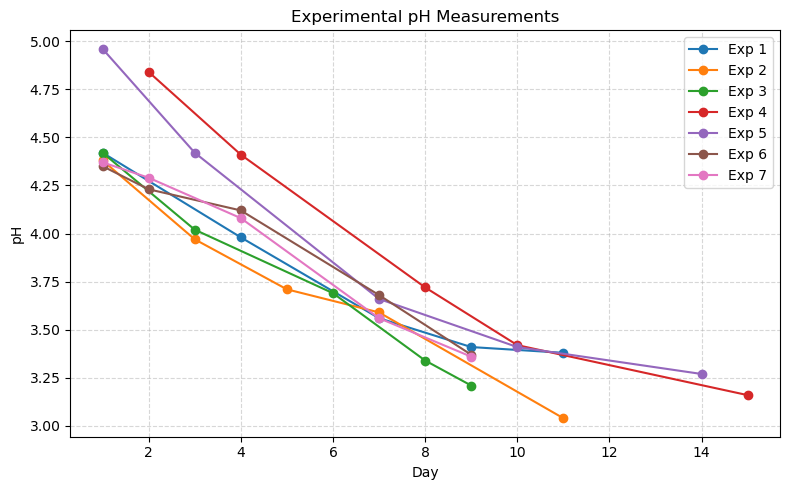

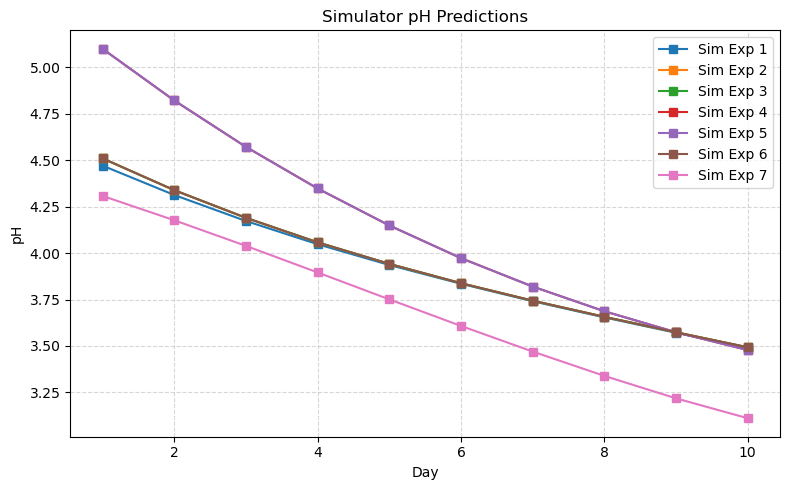

In [ ]:
# Simple pH vs. Day plots (all experiments)

plt.figure(figsize=(8,5))
for exp_num, grp in exp.groupby('Exp_Nr'):
    plt.plot(grp['Day'], grp['pH_exp'], '-o', label=f'Exp {exp_num}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Day'); plt.ylabel('pH')
plt.title('Experimental pH Measurements')
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,5))
for exp_num, grp in sim.groupby('Exp_Nr'):
    plt.plot(grp['Day'], grp['pH_dt'], '-s', label=f'Sim Exp {exp_num}')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Day'); plt.ylabel('pH')
plt.title('Simulator pH Predictions')
plt.legend(); plt.tight_layout(); plt.show()


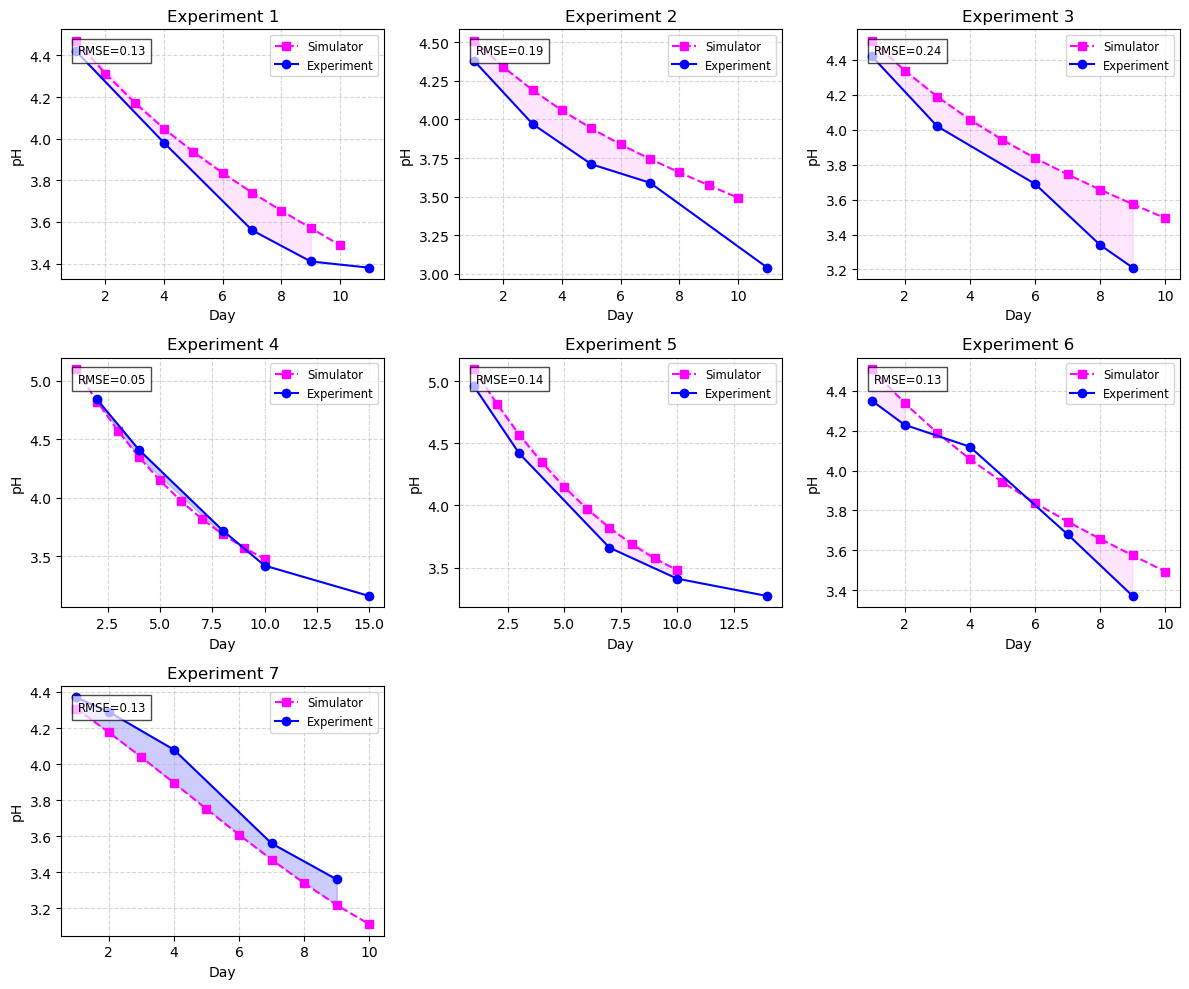

In [ ]:
# Combined real vs. sim per experiment with RMSE shading


exp_ids = sorted(exp['Exp_Nr'].unique())
fig, axes = plt.subplots(3, 3, figsize=(12,10))
axes = axes.flatten()

for ax, exp_num in zip(axes, exp_ids):
    df_e = exp .loc[exp['Exp_Nr']==exp_num].sort_values('Day')
    df_s = sim .loc[sim['Exp_Nr']==exp_num].sort_values('Day')
    
    # plot sim first
    ax.plot(df_s['Day'], df_s['pH_dt'],
            marker='s', linestyle='--', color='magenta', label='Simulator')
    # then real
    ax.plot(df_e['Day'], df_e['pH_exp'],
            marker='o', linestyle='-', color='blue', label='Experiment')
    
    # shade differences on overlapping days
    common = np.intersect1d(df_s['Day'], df_e['Day'])
    if common.size:
        y_e = df_e.set_index('Day')['pH_exp'].reindex(common)
        y_s = df_s.set_index('Day')['pH_dt'].reindex(common)
        ax.fill_between(common, y_e, y_s,
                        where=(y_e>y_s), color='blue', alpha=0.2)
        ax.fill_between(common, y_e, y_s,
                        where=(y_e<y_s), color='magenta', alpha=0.1)
        # compute RMSE
        diffs = (y_s - y_e).values
        rmse = np.sqrt(np.mean(diffs**2)) if diffs.size else np.nan
        ax.text(0.05, 0.9, f'RMSE={rmse:.2f}',
                transform=ax.transAxes, fontsize='small',
                bbox=dict(facecolor='white', alpha=0.7))
    
    ax.set_title(f'Experiment {exp_num}')
    ax.set_xlabel('Day'); ax.set_ylabel('pH')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize='small')

# hide unused subplots
for ax in axes[len(exp_ids):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [ ]:
# Compute metrics (MAE, RMSE, nRMSE, MAPE, AUC_err, DTW) per experiment


# 1) merge real & sim on (Exp_Nr, Day)
df = pd.merge(
    exp[['Exp_Nr','Day','pH_exp']],
    sim[['Exp_Nr','Day','pH_dt']],
    on=['Exp_Nr','Day'],
    how='inner'
)
if df.empty:
    raise RuntimeError("No matching Exp_Nr & Day rows to compute metrics.")

# 2) metric function
def compute_metrics(y_exp, y_dt):
    err   = y_dt - y_exp
    mae   = np.mean(np.abs(err))
    rmse  = np.sqrt(np.mean(err**2))
    nrmse = rmse / (y_exp.max() - y_exp.min()) if y_exp.max()>y_exp.min() else np.nan
    mape  = np.mean(np.abs(err / y_exp)) * 100
    auc_e = abs(np.trapz(y_dt, dx=1) - np.trapz(y_exp, dx=1))
    dtw_d, _ = fastdtw(y_dt, y_exp)
    return mae, rmse, nrmse, mape, auc_e, dtw_d

# 3) compute per Exp_Nr
metrics = []
for eid, grp in df.groupby('Exp_Nr'):
    y_e = grp['pH_exp'].values
    y_s = grp['pH_dt'].values
    metrics.append((eid, *compute_metrics(y_e, y_s)))

# 4) DataFrame of metrics
cols = ['Exp_Nr','MAE','RMSE','nRMSE','MAPE','AUC_err','DTW_dist']
metrics_df = pd.DataFrame(metrics, columns=cols).set_index('Exp_Nr')
metrics_df


,MAE,RMSE,nRMSE,MAPE,AUC_err,DTW_dist
Exp_Nr,,,,,,
1,0.11525,0.128362,0.127091,3.167017,0.355,0.461
2,0.18400,0.188971,0.239204,4.763165,0.594,0.536
3,0.21780,0.241615,0.199682,6.221295,0.862,1.039
4,0.04275,0.046425,0.032693,1.090200,0.075,0.171
5,0.13000,0.135026,0.087113,3.156804,0.416,0.520
6,0.11980,0.131937,0.134630,3.110478,0.293,0.599
7,0.11820,0.125485,0.124243,3.063376,0.489,0.591


Paired t-test: t = 3.58, p = 0.001


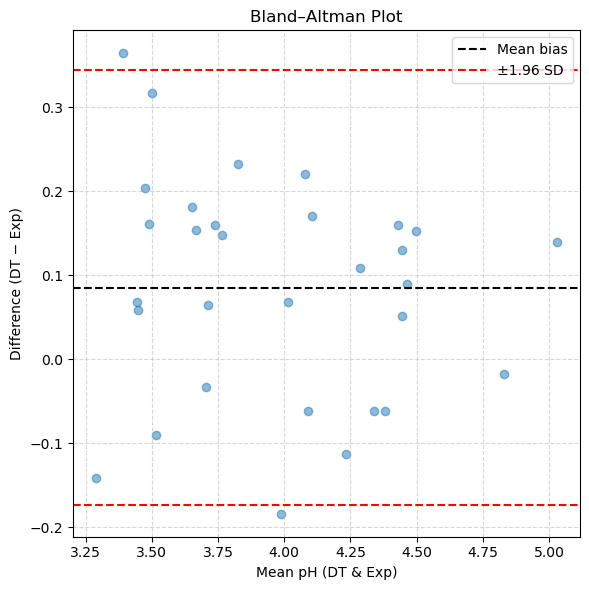

In [ ]:
# Statistical Bias Test & Bland–Altman Plot

# 1) Paired t-test between simulator and experiment pH
diffs = df['pH_dt'] - df['pH_exp']
tstat, pval = st.ttest_rel(df['pH_dt'], df['pH_exp'])
print(f"Paired t-test: t = {tstat:.2f}, p = {pval:.3f}")

# 2) Bland–Altman
means = (df['pH_dt'] + df['pH_exp']) / 2
mu, sd = diffs.mean(), diffs.std()

plt.figure(figsize=(6,6))
plt.scatter(means, diffs, alpha=0.5)
plt.axhline(mu,           linestyle='--', color='black', label='Mean bias')
plt.axhline(mu + 1.96*sd, linestyle='--', color='red',   label='±1.96 SD')
plt.axhline(mu - 1.96*sd, linestyle='--', color='red')
plt.xlabel('Mean pH (DT & Exp)')
plt.ylabel('Difference (DT − Exp)')
plt.title('Bland–Altman Plot')
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
# Slope Error & Tipping Point Timing

threshold = 3.8
results = []

for exp_id, grp in df.groupby('Exp_Nr'):
    X = grp['Day'].values.reshape(-1,1)
    y_exp = grp['pH_exp'].values
    y_dt  = grp['pH_dt'].values

    # Linear slopes
    lr_e = LinearRegression().fit(X, y_exp)
    lr_d = LinearRegression().fit(X, y_dt)
    slope_err = lr_d.coef_[0] - lr_e.coef_[0]

    # Tipping day: first day pH < threshold
    days = grp['Day'].values
    tip_e = days[np.where(y_exp < threshold)[0][0]] if np.any(y_exp < threshold) else np.nan
    tip_d = days[np.where(y_dt < threshold)[0][0]] if np.any(y_dt < threshold) else np.nan
    dtip = tip_d - tip_e

    results.append((exp_id, slope_err, dtip))

shape_df = pd.DataFrame(results, columns=['Exp_Nr','Slope_err','ΔTip_day']).set_index('Exp_Nr')
shape_df


,Slope_err,ΔTip_day
Exp_Nr,,
1,0.016837,0
2,0.004200,2
3,0.031403,2
4,0.009050,0
5,-0.006851,3
6,0.005066,0
7,-0.004721,0


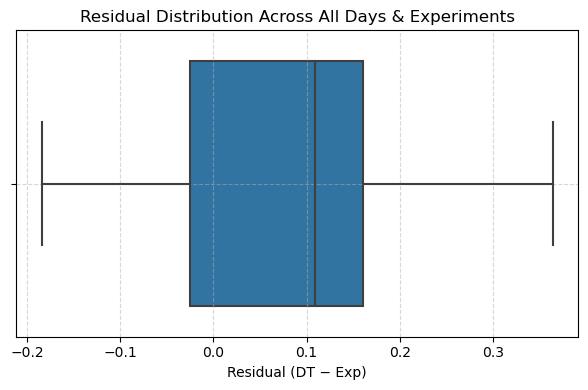

In [ ]:
# Boxplot of Residuals Across All Experiments


residuals = df['pH_dt'] - df['pH_exp']

plt.figure(figsize=(6,4))
sns.boxplot(x=residuals)
plt.xlabel('Residual (DT − Exp)')
plt.title('Residual Distribution Across All Days & Experiments')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Digital Twin Values

In [ ]:
# 1) Define analyte column mappings
analyte_map = {
    'Ethanol':     {'exp':'Ethanol [mg/L]',     'sim':'Ethanol [g/L]'},
    'Acetic acid': {'exp':'Acetic acid [mg/L]', 'sim':'Essigsäure [mg/l]'},
    'Fructose':    {'exp':'Fructose[mg/L]',     'sim':'Fructose [g/l]'},
    'Glucose':     {'exp':'Glucose [mg/L]',      'sim':'Glucose [g/l]'},
    'Saccharose':  {'exp':'Saccharose [mg/L]',   'sim':'Saccharose [g/l]'}
}

# 2) Load and clean experimental data
exp = (
    pd.read_excel('data_experiments/Data_values_from_experiments.xlsx')
      .dropna(subset=['Exp_Nr','Day'])
      .assign(
          Exp_Nr=lambda df: pd.to_numeric(df['Exp_Nr'], errors='coerce').astype(int),
          Day   =lambda df: pd.to_numeric(df['Day'],    errors='coerce').astype(int)
      )
      .dropna(subset=['Exp_Nr','Day'])
)

# Convert each analyte from mg/L → g/L
for name, cols in analyte_map.items():
    exp_col = cols['exp']
    out_col = f"{name}_g_L"
    exp[out_col] = pd.to_numeric(exp[exp_col], errors='coerce') / 1000

# 3) Load and clean simulator data
sim = (
    pd.read_excel('data_experiments/kombucha_simulator.xlsx')
      .dropna(subset=['Exp_Nr','Day'])
      .assign(
          Exp_Nr=lambda df: pd.to_numeric(df['Exp_Nr'], errors='coerce').astype(int),
          Day   =lambda df: pd.to_numeric(df['Day'],    errors='coerce').astype(int)
      )
      .dropna(subset=['Exp_Nr','Day'])
)

# Rename simulator columns to match g/L and add `_dt` suffix
for name, cols in analyte_map.items():
    sim_col = cols['sim']
    out_col = f"{name}_g_L_dt"
    sim[out_col] = pd.to_numeric(sim[sim_col], errors='coerce')

# 4) Subset relevant columns and inner‐merge
exp_sub = exp[['Exp_Nr','Day'] + [f"{a}_g_L" for a in analyte_map]]
sim_sub = sim[['Exp_Nr','Day'] + [f"{a}_g_L_dt" for a in analyte_map]]

merged_all = pd.merge(
    exp_sub, sim_sub,
    on=['Exp_Nr','Day'],
    how='inner'
)

print("Merged columns:", merged_all.columns.tolist())
merged_all.tail()


Merged columns: ['Exp_Nr', 'Day', 'Ethanol_g_L', 'Acetic acid_g_L', 'Fructose_g_L', 'Glucose_g_L', 'Saccharose_g_L', 'Ethanol_g_L_dt', 'Acetic acid_g_L_dt', 'Fructose_g_L_dt', 'Glucose_g_L_dt', 'Saccharose_g_L_dt']


,Exp_Nr,Day,Ethanol_g_L,Acetic acid_g_L,Fructose_g_L,Glucose_g_L,Saccharose_g_L,Ethanol_g_L_dt,Acetic acid_g_L_dt,Fructose_g_L_dt,Glucose_g_L_dt,Saccharose_g_L_dt
62,7,5,NaN,NaN,NaN,NaN,NaN,2.908,1504.919,4.613,4.967,74.557
63,7,6,NaN,NaN,NaN,NaN,NaN,3.274,2297.262,5.886,7.046,69.215
64,7,7,NaN,NaN,NaN,NaN,NaN,3.622,3263.054,7.226,9.261,63.533
65,7,8,NaN,NaN,NaN,NaN,NaN,3.965,4376.977,8.591,11.484,57.785
66,7,9,3.551576,1.0746,2.868714,2.389182,96.567328,4.315,5613.710,9.936,13.588,52.241


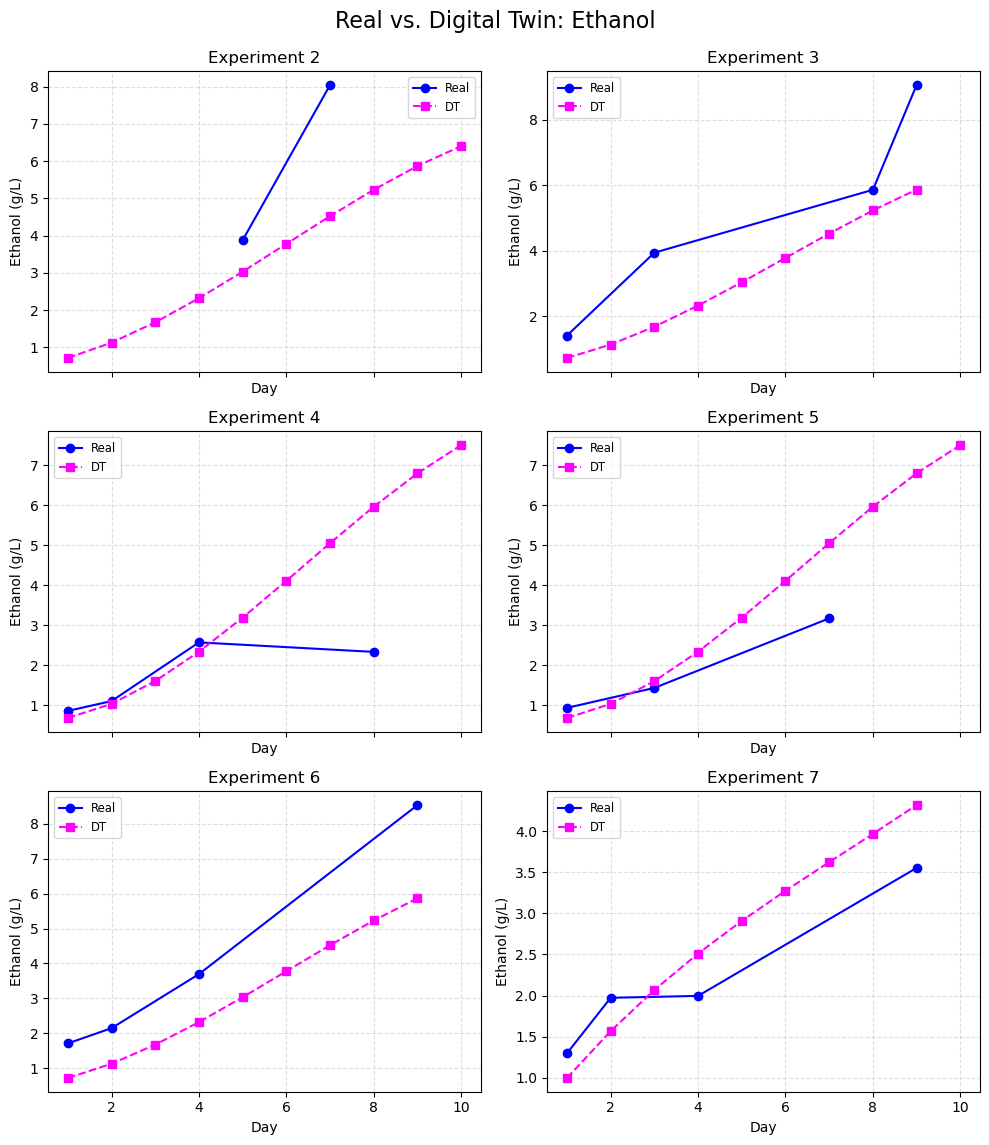

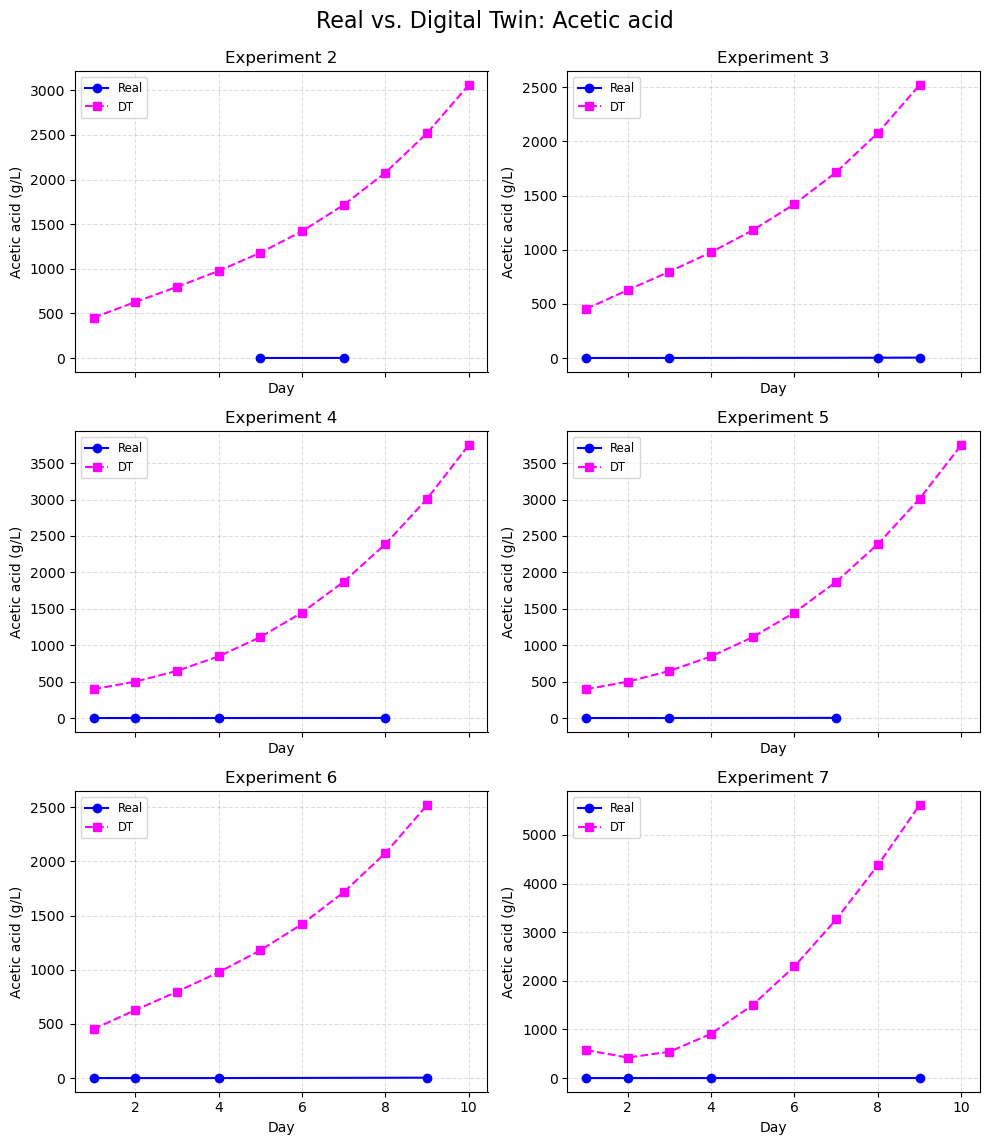

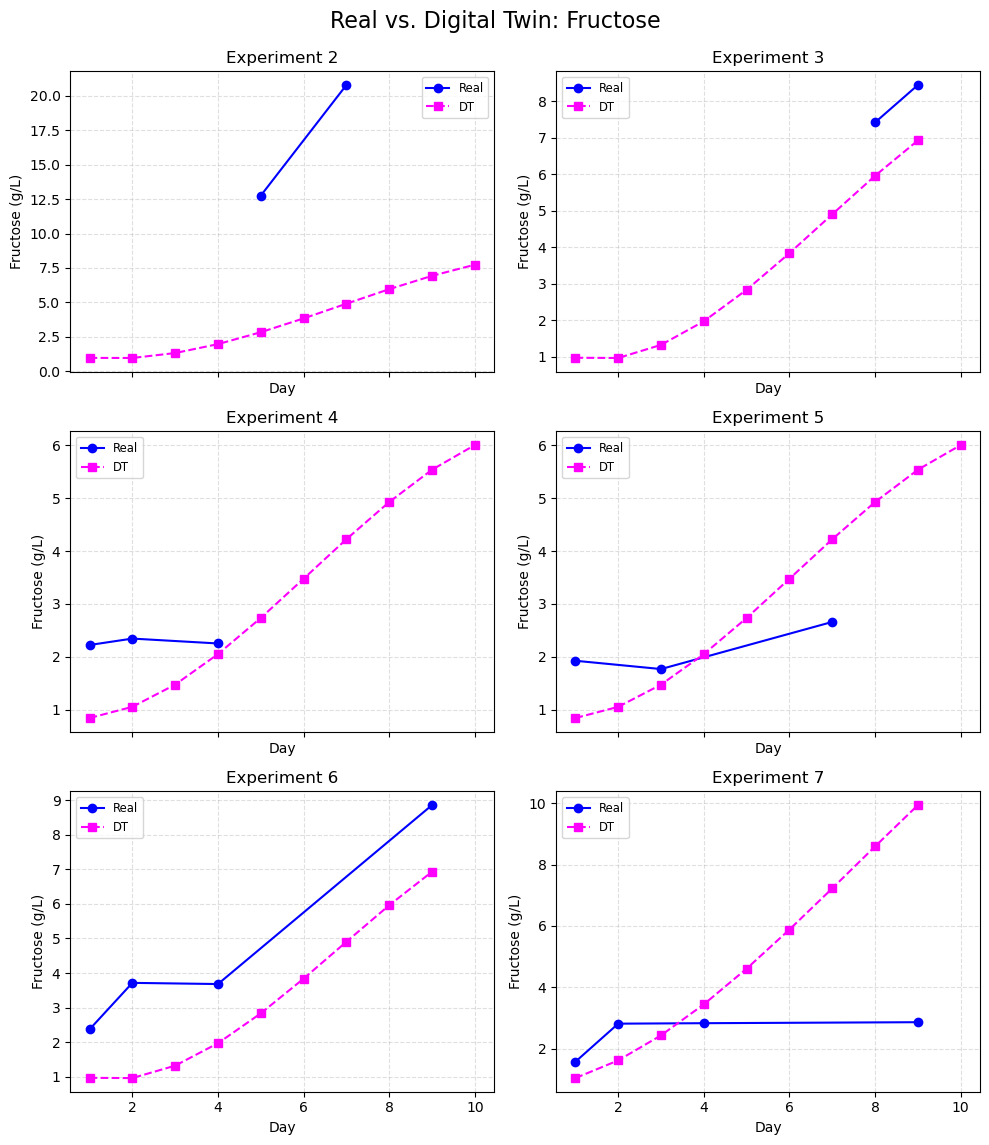

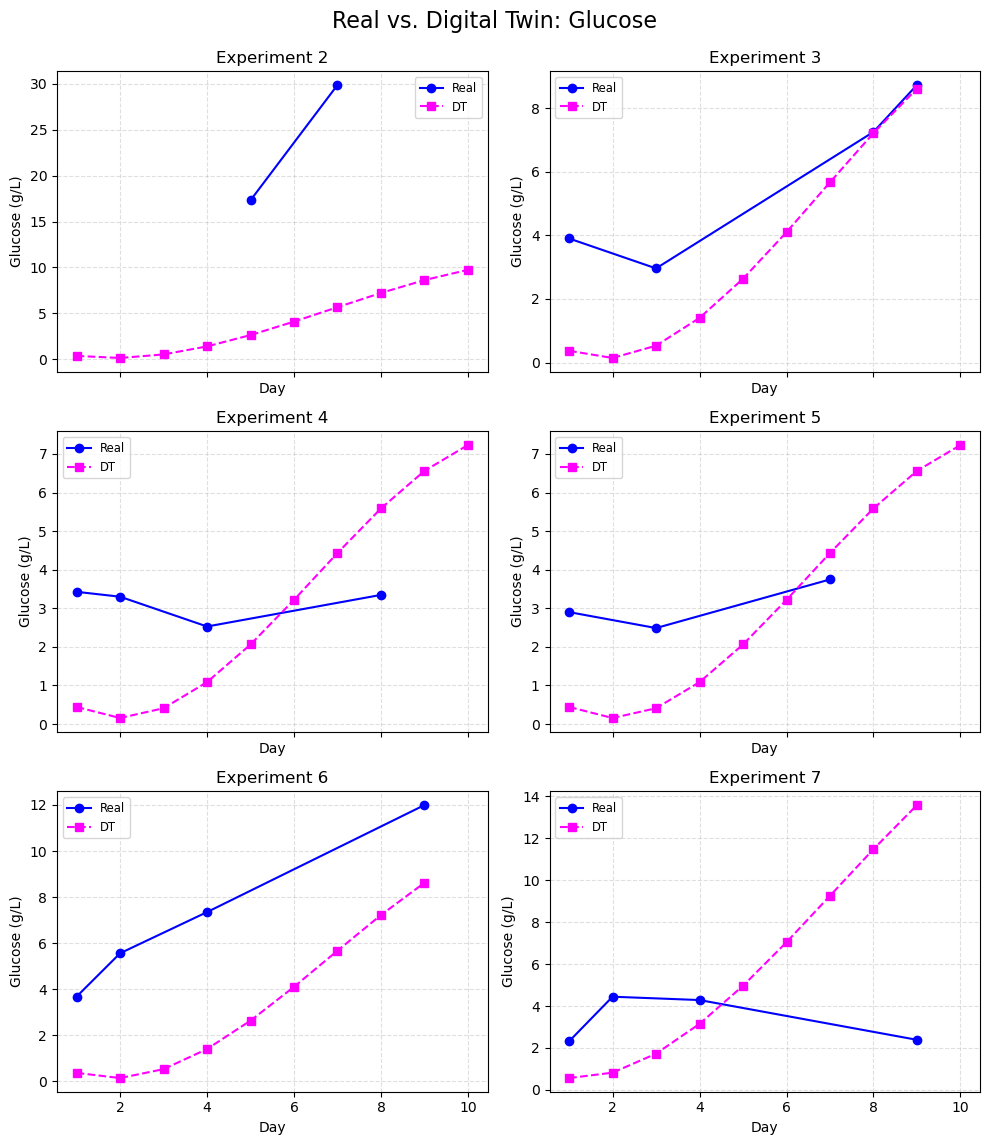

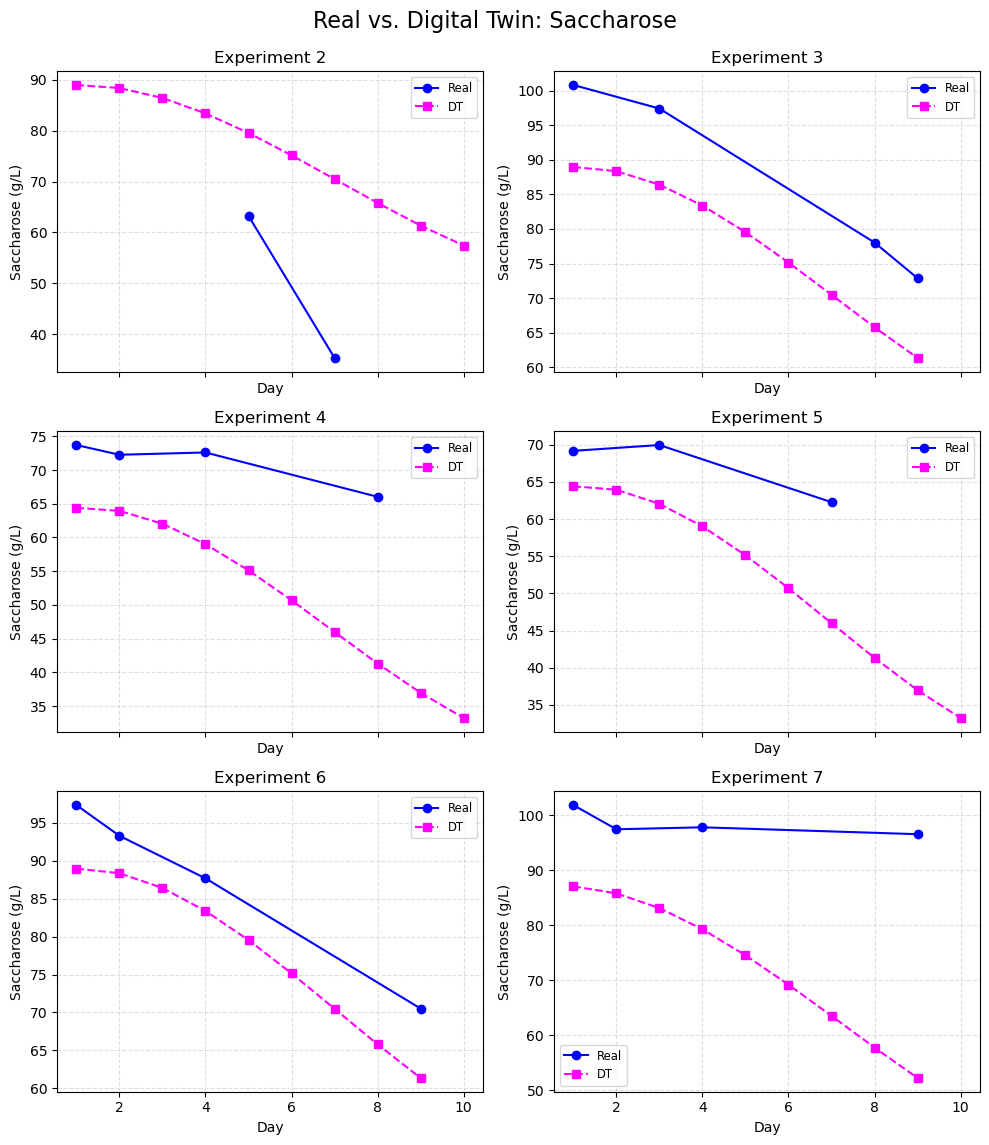

In [12]:
for analyte in analytes:
    exp_col = f"{analyte}_g_L"
    dt_col  = f"{analyte}_g_L_dt"

    fig, axes = plt.subplots(3, 2, figsize=(10,12), sharex=True)
    axes = axes.flatten()

    for ax, exp_id in zip(axes, exps):
        sub = merged_all[merged_all['Exp_Nr']==exp_id]

        # 1) real data: drop NaNs, sort
        real = sub[['Day', exp_col]].dropna().sort_values('Day')
        # 2) DT data: same
        dt   = sub[['Day', dt_col ]].dropna().sort_values('Day')

        # choose linestyle only if >1 point
        ls_real = '-'  if len(real) > 1 else 'None'
        ls_dt   = '--' if len(dt)   > 1 else 'None'

        # plot them
        ax.plot(real['Day'], real[exp_col],
                marker='o', linestyle=ls_real,
                color='blue', label='Real')
        ax.plot(dt['Day'], dt[dt_col],
                marker='s', linestyle=ls_dt,
                color='magenta', label='DT')

        ax.set_title(f'Experiment {exp_id}')
        ax.set_xlabel('Day')
        ax.set_ylabel(f'{analyte} (g/L)')
        ax.grid(True, ls='--', alpha=0.4)
        ax.legend(fontsize='small')

    # hide any extra axes
    for ax in axes[len(exps):]:
        ax.set_visible(False)

    fig.suptitle(f'Real vs. Digital Twin: {analyte}', fontsize=16, y=0.95)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()
